In [2]:
import os
import cv2
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imgaug.augmenters as iaa
from itertools import chain
from pathlib import Path
from skimage.io import imread, imshow
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Graphing
import seaborn as sns

# Check for GPU and allocate a fixed amount of GPU mem
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
  except RuntimeError as e:
    print(e)
else:
    print("WARNING: NO GPU FOUND")


In [3]:
base_path = Path('C://Users//Gabriel//Desktop//CS3244//PneumoniaCNN')

# Base file path for data
data_path = base_path / 'data' / 'pneumonia_data' / 'chest_xray_binary'

# File path for training images
train_path = data_path / 'train'

# File path for testing images
test_path = data_path / 'test'


# RSNA Data
rsna_data_path = base_path / 'data' / 'rsna_data_scaled'

rsna_train_path = rsna_data_path / 'train'

In [4]:
image_shape = (128, 128, 1)

batch_size = 16

In [5]:
# from sklearn.model_selection import train_test_split
# from skimage.transform import resize
# from skimage.color import rgb2gray

# data = []
# labels = []

# for image_path in rsna_normal_path.glob('*.jpg'):
#     img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, image_shape[:2]) 
#     img = img[:, :, np.newaxis]
#     img = img.astype(np.float32)/255
#     data.append(img)
#     labels.append(0)

# for image_path in rsna_pneumonia_path.glob('*.jpg'):
#     img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, image_shape[:2]) 
#     img = img[:, :, np.newaxis]
#     img = img.astype(np.float32)/255
#     data.append(img)
#     labels.append(1)
    
# data = np.array(data)
# labels = np.array(labels)

Normal
Img Shape: (1010, 1462)


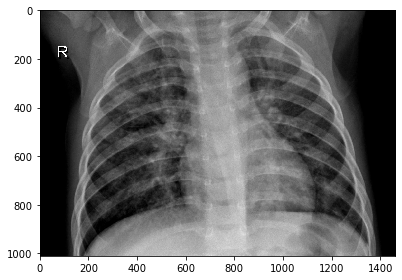

In [6]:
from skimage.exposure import equalize_adapthist, equalize_hist

def equalize_adaptivehist(image):
    return equalize_adapthist(image, clip_limit=0.03)

sample_image_path = test_path / 'PNEUMONIA' / 'person19_virus_50.jpeg'
sample_image = imread(sample_image_path)
enhanced_sample_image = equalize_hist(sample_image)

print("Normal")
print("Img Shape: " + str(sample_image.shape))
imshow(sample_image)

CLAHE
Img Shape: (1010, 1462)


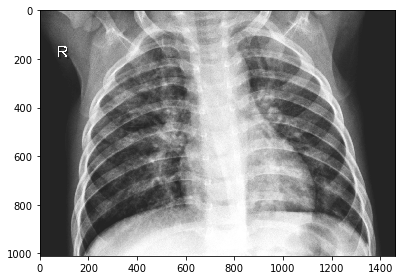

In [7]:
print("CLAHE")
print("Img Shape: " + str(enhanced_sample_image.shape))

imshow(enhanced_sample_image)

In [8]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               brightness_range=[0.8,1.2], # Vary brightness between range +-
                               horizontal_flip=True,
                               fill_mode='nearest'
                              )

In [9]:
rsna_image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               brightness_range=[0.8,1.2], # Vary brightness between range +-
                               horizontal_flip=True,
                               fill_mode='nearest',
                               validation_split=0.2
                              )

In [10]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary')

test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
rsna_train_image_gen = rsna_image_gen.flow_from_directory(rsna_train_path,
                                               target_size=image_shape[:2],
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary',
                                               subset='training')

rsna_test_image_gen = rsna_image_gen.flow_from_directory(rsna_train_path,
                                               target_size=image_shape[:2],
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary',
                                               subset='validation',
                                               shuffle=False)

Found 21348 images belonging to 2 classes.
Found 5336 images belonging to 2 classes.


In [12]:
train_image_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [13]:
rsna_train_image_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [84]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dropout, Flatten, Dense, AlphaDropout
from tensorflow.keras.layers import Conv2D, SeparableConv2D, AveragePooling2D, DepthwiseConv2D,MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import binary_crossentropy
from tensorflow.keras.layers import Multiply

In [85]:
model_input = Input(shape=image_shape)

# Feature indentification and reduction
feature_extraction_layer = Conv2D(32, (3,3), activation='relu', padding='same')(model_input)
feature_extraction_layer = Conv2D(32, (3,3), activation='relu', padding='same')(feature_extraction_layer)
feature_extraction_layer = BatchNormalization()(feature_extraction_layer)

feature_extraction_layer = Conv2D(64, (3,3), activation='relu')(feature_extraction_layer)
feature_extraction_layer = Conv2D(64, (3,3), activation='relu')(feature_extraction_layer)
feature_extraction_layer = BatchNormalization()(feature_extraction_layer)

feature_extraction_layer = Conv2D(96, (3,3), activation='relu')(feature_extraction_layer)
feature_extraction_layer = Conv2D(96, (3,3), activation='relu')(feature_extraction_layer)
feature_extraction_layer = BatchNormalization()(feature_extraction_layer)

a1 = Conv2D(96, (3,3), activation='relu', padding='same', strides=(2,2))(feature_extraction_layer)

a2 = MaxPooling2D((2,2))(feature_extraction_layer)

feature_reduction_layer = concatenate([a1, a2])

y1 = Conv2D(128, (3,3), activation='relu', padding='same', strides=(2,2))(feature_reduction_layer)

y2 = Conv2D(128, (1,1), activation='relu')(feature_reduction_layer)
y2 = MaxPooling2D((2,2))(y2)

second_reduction_layer = concatenate([y1, y2])

x1 = Conv2D(128, (1,1), activation='relu')(second_reduction_layer)

x2 = Conv2D(128, (1,1), activation='relu')(second_reduction_layer)
x2 = Conv2D(96, (3,3), activation='relu', padding='same')(x2)

x3 = Conv2D(128, (1,1), activation='relu')(second_reduction_layer)
x3 = Conv2D(96, (5,5), activation='relu', padding='same')(x3)

x4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(second_reduction_layer)
x4 = Conv2D(128, (1,1), activation='relu')(x4)

inception_layer_1 = concatenate([x1, x2, x3, x4])

z1 = DepthwiseConv2D((3,3), activation='relu', padding='same')(inception_layer_1)
z1 = DepthwiseConv2D((3,3), activation='relu', padding='same', strides=(2,2))(z1)
z1 = BatchNormalization()(z1)

z2 = Conv2D(320, (1,1), activation='relu')(inception_layer_1)
z2 = MaxPooling2D((2,2))(z2)

final_reduction_layer = concatenate([z1, z2])

model = AveragePooling2D((15,15))(final_reduction_layer)


# model = SeparableConv2D(128, (3,3), activation='relu')(model)
# model = BatchNormalization()(model)

# model = SeparableConv2D(96, (3,3), activation='relu')(model)
# model = BatchNormalization()(model)

# model = MaxPooling2D((2,2))(model)
# model = SeparableConv2D(48, (1,1), activation='relu')(model)

model = Flatten()(model)

model = Dense(128, activation='relu')(model)

model = BatchNormalization()(model)

# model = Dense(64, activation='relu')(model)

# model = BatchNormalization()(model)

model_output = Dense(1, activation='sigmoid')(model)

model = Model(inputs=model_input, outputs=model_output)


model.compile(loss='binary_crossentropy',
              optimizer='RMSProp',
              metrics=['accuracy'])

# model_input = Input(shape=image_shape)

# conv_layer_1 = Conv2D(64, (3,3), activation='relu', padding='same')(model_input)
# conv_layer_1 = Conv2D(64, (3,3), activation='relu')(conv_layer_1)
# conv_layer_1 = BatchNormalization()(conv_layer_1)
# pooling_layer_1 = MaxPooling2D((2,2))(conv_layer_1)

# # conv_layer_2 = SeperableConv2D(128, (3,3), activation='relu', padding='same')(pooling_layer_1)
# # conv_layer_2 = BatchNormalization()(conv_layer_2)
# # pooling_layer_2 = MaxPooling2D((2,2))(conv_layer_2)

# conv_layer_2 = Conv2D(128, (3,3), activation='relu')(pooling_layer_1)
# conv_layer_2 = Conv2D(128, (3,3), activation='relu')(conv_layer_2)
# conv_layer_2 = BatchNormalization()(conv_layer_2)
# pooling_layer_2 = MaxPooling2D((2,2))(conv_layer_2)

# # # Inception v2
# # conv_layer_2 = Conv2D(32, (3,3), activation='relu', padding='same')(pooling_layer_1)
# # conv_layer_2 = BatchNormalization()(conv_layer_2)
# # pooling_layer_2 = MaxPooling2D((2,2))(conv_layer_2)
# # pooling_layer_2 = Conv2D(128, (1,1), activation='relu')(pooling_layer_2)

# x1 = Conv2D(48, (1,1), activation='relu')(pooling_layer_2)
# # x1 = BatchNormalization()(x1)

# x2 = Conv2D(48, (1,1), activation='relu')(pooling_layer_2)
# # x2 = BatchNormalization()(x2)
# x2 = Conv2D(32, (3,3), activation='relu', padding='same')(x2)

# x3 = Conv2D(48, (1,1), activation='relu')(pooling_layer_2)
# # x3 = BatchNormalization()(x3)
# x3 = Conv2D(32, (5,5), activation='relu', padding='same')(x3)

# x4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(pooling_layer_2)
# x4 = Conv2D(48, (1,1), activation='relu')(x4)
# # x4 = BatchNormalization()(x4)

# inception_layer = concatenate([x1, x2, x3, x4])

# # # Inception v2

# model = SeparableConv2D(120, (3,3), activation='relu')(inception_layer)

# model = BatchNormalization()(model)

# model = SeparableConv2D(80, (3,3), activation='relu')(model)

# model = BatchNormalization()(model)

# model = Conv2D(48, (1,1), activation='relu')(model)

# model = BatchNormalization()(model)

# model = MaxPooling2D((2,2))(model)

# model = Flatten()(model)

# model = Dense(128, activation='relu')(model)

# model = BatchNormalization()(model)

# # model = Dropout(0.5)(model)

# model_output = Dense(1, activation='sigmoid')(model)

# model = Model(inputs=model_input, outputs=model_output)

# model.compile(loss='binary_crossentropy',
#               optimizer='RMSProp',
#               metrics=['accuracy'])



In [86]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_221 (Conv2D)             (None, 128, 128, 32) 320         input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_222 (Conv2D)             (None, 128, 128, 32) 9248        conv2d_221[0][0]                 
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 128, 128, 32) 128         conv2d_222[0][0]                 
___________________________________________________________________________________________

In [87]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras import backend as K

class printLR(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(K.eval(self.model.optimizer.lr))
        
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [88]:
results = model.fit(train_image_gen,epochs=30,
                              validation_data=test_image_gen,
                               callbacks=[ReduceLROnPlateau(), 
                                          ModelCheckpoint('checkpoint.h5',save_best_only=True)])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 326 steps, validate for 39 steps
Epoch 1/30
326/326 [==============================] - 59s 182ms/step - loss: 0.3787 - accuracy: 0.8319 - val_loss: 1.0793 - val_accuracy: 0.5609
Epoch 2/30
326/326 [==============================] - 59s 180ms/step - loss: 0.2955 - accuracy: 0.8723 - val_loss: 1.0828 - val_accuracy: 0.6250
Epoch 3/30
326/326 [==============================] - 59s 182ms/step - loss: 0.2584 - accuracy: 0.8926 - val_loss: 0.9412 - val_accuracy: 0.7099
Epoch 4/30
326/326 [==============================] - 59s 180ms/step - loss: 0.2391 - accuracy: 0.8990 - val_loss: 2.3283 - val_accuracy: 0.6250
Epoch 5/30
326/326 [==============================] - 59s 179ms/step - loss: 0.2318 - accuracy: 0.9057 - val_loss: 1.2613 - val_accuracy: 0.5096
Epoch 6/30
326/326 [==============================] - 58s 178ms/step - loss: 0.2206 - accuracy: 0.9107 - val_loss: 0.9446 - val_accuracy: 0.6587
Epoch 7/30
326/326 [=================

In [89]:
model.save('curr_model.h5')

losses = pd.DataFrame(model.history.history)

In [90]:
from tensorflow.keras.models import load_model

def get_test_data(dataset):
    if dataset == 'rsna':
        return rsna_test_image_gen

    if dataset == 'original':
        return test_image_gen


def print_stats(model, dataset):
    
    testX = get_test_data(dataset)
    testY = testX.classes
    
    
    model.evaluate(testX)
    
    # Processing probabilities
    pred_probabilities = model.predict(testX)
    predictions = pred_probabilities > 0.5
    
    # Only for binary classification
    print(classification_report(testY, predictions))
    
    # Print Confusion Matrix
    cm  = confusion_matrix(testY, predictions)
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
    plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.show()

  ...
    to  
  ['...']
334/334 [==============================] - 12s 35ms/step - loss: 1618.1948 - accuracy: 0.6915
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      3690
           1       0.00      0.00      0.00      1646

    accuracy                           0.69      5336
   macro avg       0.35      0.50      0.41      5336
weighted avg       0.48      0.69      0.57      5336



c:\users\gabriel\miniconda3\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

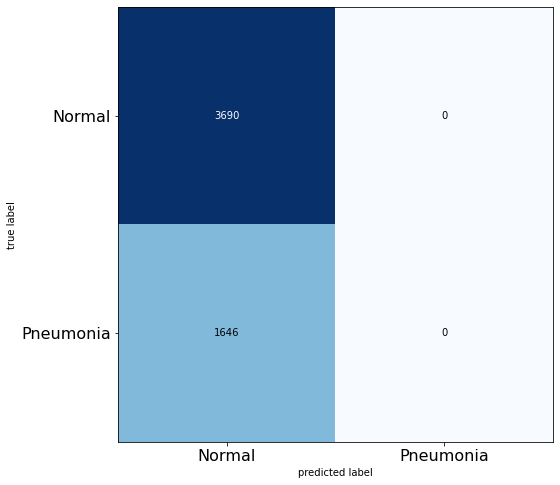

  ...
    to  
  ['...']
39/39 [==============================] - 5s 136ms/step - loss: 0.4383 - accuracy: 0.8333
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       234
           1       0.89      0.89      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.85      0.85       624
weighted avg       0.86      0.86      0.86       624



<Figure size 432x288 with 0 Axes>

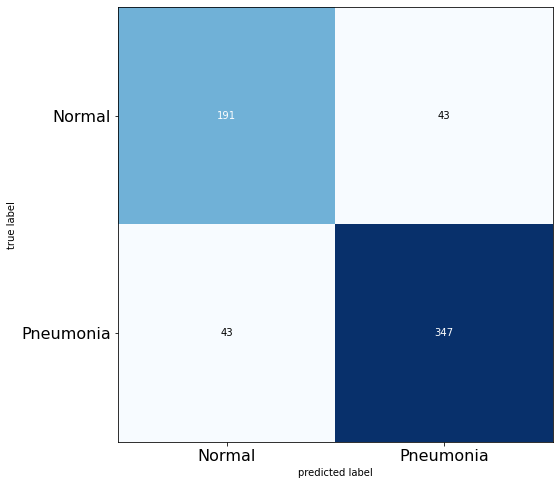

In [91]:
best_model = load_model('checkpoint.h5')

print_stats(best_model, 'rsna')
print_stats(best_model, 'original')

  ...
    to  
  ['...']
334/334 [==============================] - 11s 33ms/step - loss: 2320.7467 - accuracy: 0.6722
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      3690
           1       0.29      0.04      0.07      1646

    accuracy                           0.67      5336
   macro avg       0.49      0.50      0.44      5336
weighted avg       0.57      0.67      0.58      5336



<Figure size 432x288 with 0 Axes>

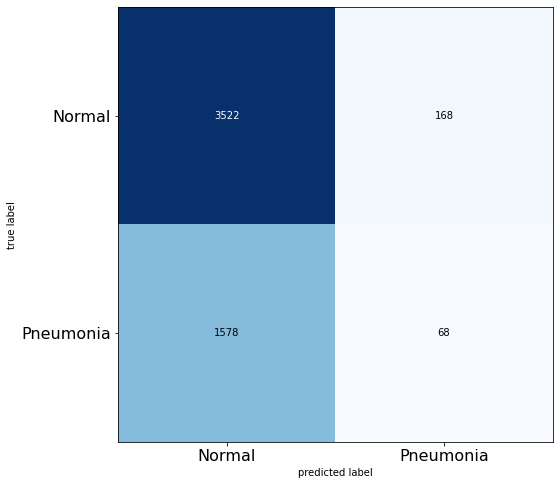

  ...
    to  
  ['...']
39/39 [==============================] - 5s 137ms/step - loss: 0.3305 - accuracy: 0.8702
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       234
           1       0.89      0.88      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.85      0.85       624
weighted avg       0.86      0.86      0.86       624



<Figure size 432x288 with 0 Axes>

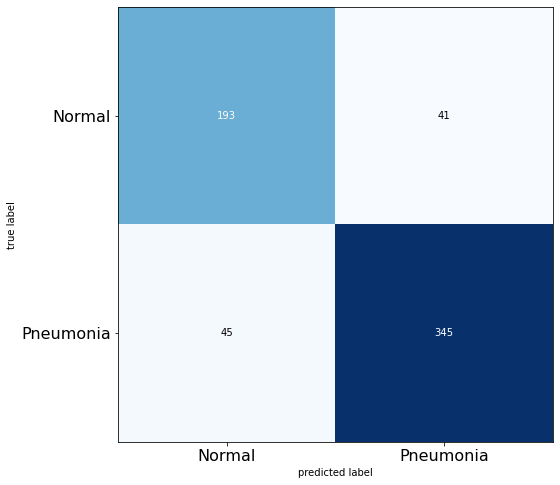

In [92]:
curr_model = load_model('curr_model.h5')

print_stats(curr_model, 'rsna')
print_stats(curr_model, 'original')

In [93]:
rsna_path = base_path / 'binary_models' / 'SAMPLES' / 'rsna_model'
best_rsna_model = load_model(rsna_path / 'checkpoint.h5')
curr_rsna_model = load_model(rsna_path / 'curr_model.h5')